Plot GNSS (cGPS) time series for one station for the last n days. Plots all three components (e,n,u) separately, but with a common time scale
--

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import scipy.signal
import sys
import matplotlib as mpl
import numpy as np
import datetime
from dateutil import parser
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, Layout
%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#filter kernel
od = 11
#default days, maximum permitted
days = '365000'

In [3]:
def selsite(s):
  global site, siteid, netid
  site = str(s['new'])
  
def seldays(d):
  global days
  days = str(d['new'])


In [5]:
def output(o):
    siteid = str.split(site, '.')[0]
    netid = str.split(site, '.')[1]
    
    #get observation statistics for last data value, FITS query
    url = 'http://fits.geonet.org.nz/observation/stats'
    payload = {'typeID': 'u', 'siteID': siteid, 'networkID': netid}
    r = requests.get(url,params=payload)
    #get from a dictionary
    jdata = r.json()
    last = jdata.get('Last').get('DateTime').encode('ascii','ignore')       #'2016-04-02T11:59:00Z'
    dtlast = parser.parse(last)     #datetime
    strlast = dtlast.strftime("%Y-%m-%d%Z") #formatted string 2016-04-03UTC

    #get time series data for sites, FITS query
    names = ['dt', 'obs', 'err']
    url= 'http://fits.geonet.org.nz/observation?typeID=e&siteID='+siteid+'&networkID='+netid+'&days='+days
    dfe = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})
    url= 'http://fits.geonet.org.nz/observation?typeID=n&siteID='+siteid+'&networkID='+netid+'&days='+days
    dfn = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})
    url= 'http://fits.geonet.org.nz/observation?typeID=u&siteID='+siteid+'&networkID='+netid+'&days='+days
    dfu = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})

    #join dataframes, rename columns
    df = pd.concat([dfe, dfn, dfu], axis=1, join='inner')
    names = ['Datetime', 'obse', 'erre', 'dtn', 'obsn', 'errn', 'dtu', 'obsu', 'erru']
    df.columns = names      #rename columns

    #reference observation columns to first value
    df['obse'] -= df['obse'][0]
    df['obsn'] -= df['obsn'][0]
    df['obsu'] -= df['obsu'][0]

    #pre-filter observations
    df['obsef'] = scipy.signal.medfilt(df['obse'],od)
    df['obsnf'] = scipy.signal.medfilt(df['obsn'],od)
    df['obsuf'] = scipy.signal.medfilt(df['obsu'],od)

    #ticks
    majorTick = mpl.dates.YearLocator(1)
    majorFormat = mpl.dates.DateFormatter('%Y')
    minorTick = mpl.dates.MonthLocator()

    #plot all data
    fig = plt.figure(figsize=(15, 7.5))
    fig.subplots_adjust(hspace=0.3)

    ax = fig.add_subplot(3, 1, 1)
    plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
    plt.plot(df['Datetime'], df['obsn'], marker='o', color='black', linestyle='None')
    plt.errorbar(df['Datetime'], df['obsn'], yerr=df['errn'], capsize=0, linestyle='None')
    plt.plot(df['Datetime'], df['obsnf'], marker='None', color='red')
    plt.ylabel('dn (mm)')
    title = (siteid+' daily position change (mm), last data '+strlast)
    plt.title(title)

    ax = fig.add_subplot(3, 1, 2)
    plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
    plt.plot(df['Datetime'], df['obse'], marker='o', color='black', linestyle='None')
    plt.errorbar(df['Datetime'], df['obse'], yerr=df['erre'], capsize=0, linestyle='None')
    plt.plot(df['Datetime'], df['obsef'], marker='None', color='red')
    plt.ylabel('de (mm)')

    ax = fig.add_subplot(3, 1, 3)
    plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
    plt.plot(df['Datetime'], df['obsu'], marker='o', color='black', linestyle='None')
    plt.errorbar(df['Datetime'], df['obsu'], yerr=df['erru'], capsize=0, linestyle='None')
    plt.plot(df['Datetime'], df['obsuf'], marker='None', color='red')
    plt.ylabel('du (mm)')

    #output plot
    if (days == '365000'):
        plt.savefig(siteid+'.png', dpi=200)
    else:
        plt.savefig(siteid+'_'+days+'.png', dpi=200)

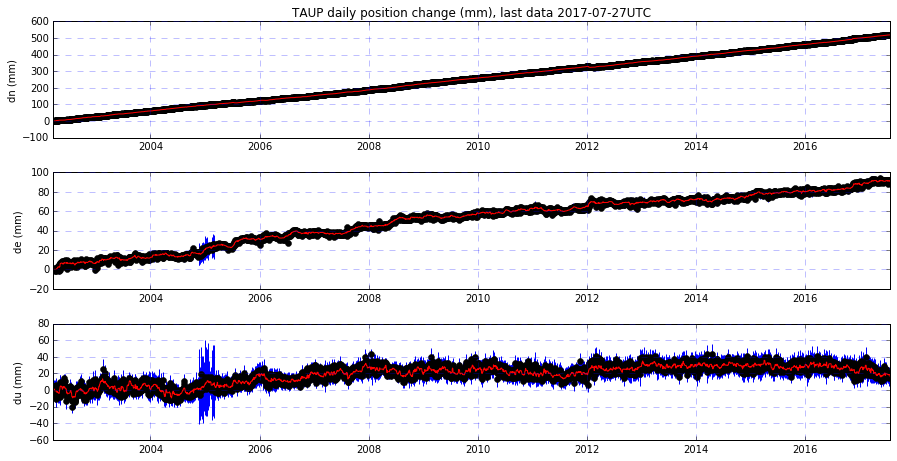

In [6]:
s = widgets.Text(
    value='',
    placeholder='',
    description='Site (eg TAUP.LI):',
    disabled=False
)
s.observe(selsite, names='value')

d = widgets.Text(
    value='',
    placeholder='',
    description='Days to plot (blank = all):',
    disabled=False
)
d.observe(seldays, names='value')

o=widgets.Button(
    description='Plot',
    disabled=False,
    button_style='success',
    tooltip='Make file copy')
o.on_click(output)

widgets.HBox([s, d, o])